# Should we ever use DiD?

Assume parallel trends. DiD nails the ATT. Would a double-machine learning (DML) estimator also be able to recover the ATT? And the ATE and ATC? When should we use DiD if we have DML?

**TLDR;** I don't see a strong argument for DiD, even with selection of unobservables, if one believes it has enough data to pick the "symptoms" of the unobservables. DiD only works sensibly better when we don't have enough data to check its assumptions. Does it make it a good scientific method?

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.theme import *
from src.dgp import DGP

In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.formula.api as smf
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.linear_model import LogisticRegressionCV
from econml.sklearn_extensions.linear_model import WeightedLassoCV
from econml.dml import CausalForestDML

## Data

Consider a panel of $N$ individuals observed at $T$ periods. Let's call $t_w$ the treatment period, $D_i$ the treatment indicator for individual $i$, and $W_{it} = D_i * (t \geq t_w)$ the treatment indicator for treated individuals after treatment.

Assume that the outcome model is

$$
Y_{it} = \alpha_i + \gamma_t + f(\alpha_i) W_{it} + \epsilon_{it}
$$

where $f(\alpha_i)$ is the treatment effect.

Suppose that consumers select into treatment depending on their expected treatment effect

$$
\mathbb{E} [f(\alpha_i)] = f(\alpha_i) + \xi_{i}
$$

In [4]:
from src.dgp import DGP

class DGPSelectionOnUnobservables(DGP):
    """DGP for selection on unobservables."""

    def __init__(self, n: int, t: int):
        super(DGPSelectionOnUnobservables, self).__init__(
            n = n,
            w = "w",
            y = ["y"],
            u = ["type_i", "shock_t", "shock_it", "e", "tau"],
        )
        self.t = t

    def initialize_data(self, seed: int = 0) -> pd.DataFrame:
        """Generates a dataframe with the baseline variables."""
        np.random.seed(seed)

        # Initialize panel data
        df = pd.DataFrame({
            "i": np.repeat(np.arange(0, self.n), self.t),
            "t": np.tile(np.arange(0, self.t), self.n),
            "type_i": np.repeat(np.random.exponential(4, self.n), self.t),
            "shock_t": np.tile(np.random.uniform(0, 2, self.t), self.n),
            "shock_it": np.random.normal(0, 0.2, self.n * self.t),
        })
        return df.round(2)

    def add_potential_outcomes(self, df: pd.DataFrame, seed: int = 0) -> pd.DataFrame:
        """Adds potential outcomes to the dataframe."""                
        df["y_w0"] = df["shock_t"] + df["type_i"] + df["shock_it"]
        df["tau"] = 3 * (np.sqrt(df["type_i"]) - 2)
        df["y_w1"] = df["y_w0"] + df["tau"]
        return df

    def add_treatment_assignment(self, df: pd.DataFrame, seed: int = 0) -> pd.DataFrame:
        """Adds the treatment assignment variable."""
        df["e"] = sp.special.expit(df["tau"])
        df["d"] = 1 * (np.repeat(np.random.uniform(0, 1, self.n), self.t) < df["e"])
        df["w"] = df["d"] * (df["t"] == (self.t - 1))
        return df

    def post_treatment_processing(self, df: pd.DataFrame, seed: int = 0):
        """Post-treatment processing: adds a wide version of the data."""
        del df["w"]
        df = df.rename(columns={"d": "w"})
        dfw = df.copy()        
        index_cols = [c for c in ["i", "type_i", "e", "w", "tau"] if c in df.columns]
        dfw = pd.pivot(dfw, index=index_cols, columns=["t"]).reset_index()
        dfw.columns = ["_t".join([str(c) for c in col if len(str(c))]) for col in dfw.columns]
        return df, dfw

Assume we have *N=10,000* individuals over *T=2* time periods. The first period is pre-treatment and the second period is treatment. 

Let's give a name and functional form to each model component. Let's assume we are an online platform with a subscription program. The outcome is customer spend. The more customers spend, the more the program is beneficial for consumers. Customers have an rough idea of whether the program is good for them and they select into it.

- Customer budget: $\alpha_i \sim \text{Exp}(4)$
- Market-level shocks: $\gamma_t \sim U(0, 2)$
- Noise: $\epsilon_{it} \sim N(0, 0.2)$
- Consumers forecast error: $\xi_{it} \sim\text{T1EV}(0, 1)$ 

The treatment effect is given by

$$
f(\alpha_i) = 3 * (\sqrt{\alpha_i} - 2)
$$

so that the average treatment effect is slightly negative.

In [5]:
dgp = DGPSelectionOnUnobservables(n=10_000, t=2)
df, dfw = dgp.generate_data(drop_unobservables=False)

This is what the data would look like without the unobservables, in wide format.

In [6]:
_, dfw_u = dgp.generate_data(drop_unobservables=True)
dfw_u.head()

,i,w,y_t0,y_t1
0,0,0,4.59,3.520000
1,1,1,6.06,6.061607
2,2,0,5.30,3.940000
3,3,0,4.57,3.560000
4,4,0,3.67,2.640000


For each individual, we know their treatment status $w$, the outcome before treatment $y_{t=0}$, and the outcome after treatment $y_{t=1}$.

## Unobservables

Since customers sort into treatment based on the expected treatment effect, the average treatment effect on the treated, ATT, is positive, while the average treatment effect on the control, ATC, is negative.

In [7]:
def print_true_effects(dfw):
    print(f"ATE: {dfw.tau.mean():.2f} ± {dfw.tau.std() / np.sqrt(len(dfw)):.2f}")
    print(f"ATT: {dfw[dfw.w==1].tau.mean():.2f} ± {dfw[dfw.w==1].tau.std() / np.sqrt(np.sum(dfw.w==1)):.2f}")
    print(f"ATC: {dfw[dfw.w==0].tau.mean():.2f} ± {dfw[dfw.w==0].tau.std() / np.sqrt(np.sum(dfw.w==0)):.2f}")

In [8]:
print_true_effects(dfw)

ATE: -0.72 ± 0.03
ATT: 1.69 ± 0.04
ATC: -2.28 ± 0.02


We can plot the whole distribution of individual treatment effects.

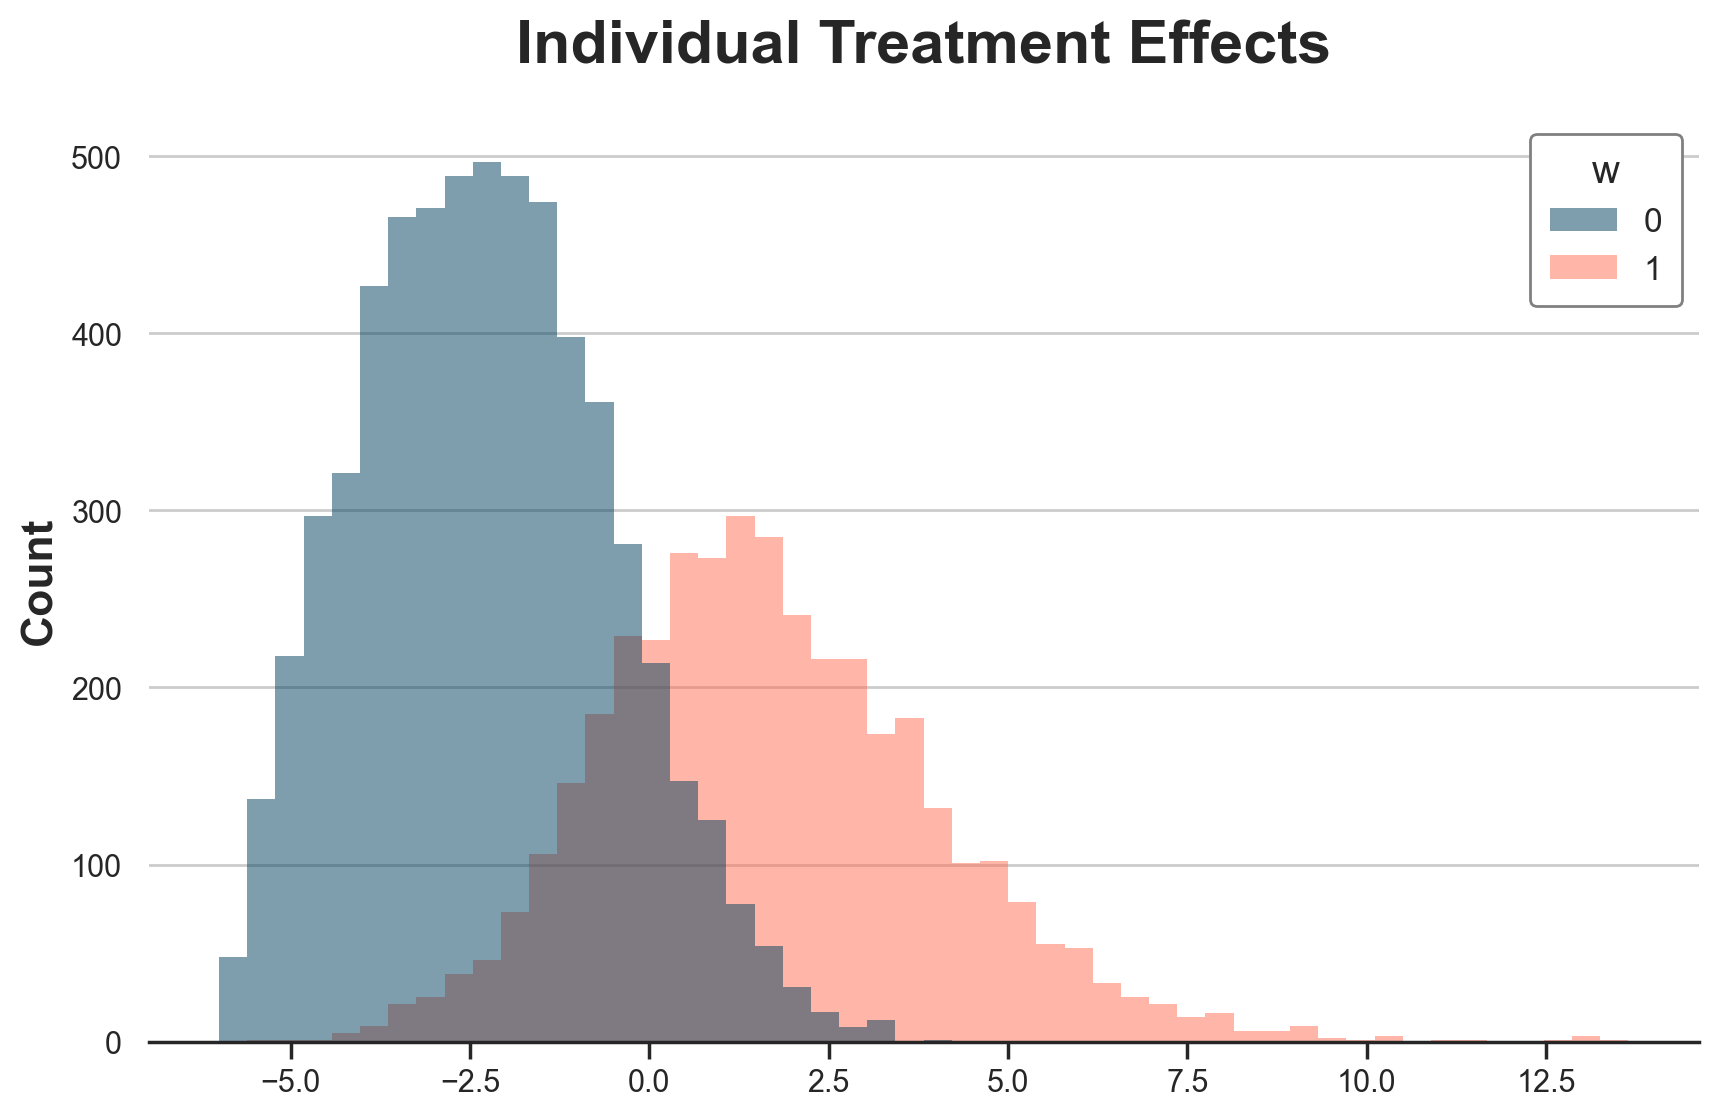

In [9]:
g = sns.histplot(data=df[df.t==0], x="tau", hue="w", bins=50);
g.set(xlabel="", title="Individual Treatment Effects");

While individual treatment effects are unobservable, they are reflected in the pre-treatment expenditure levels.

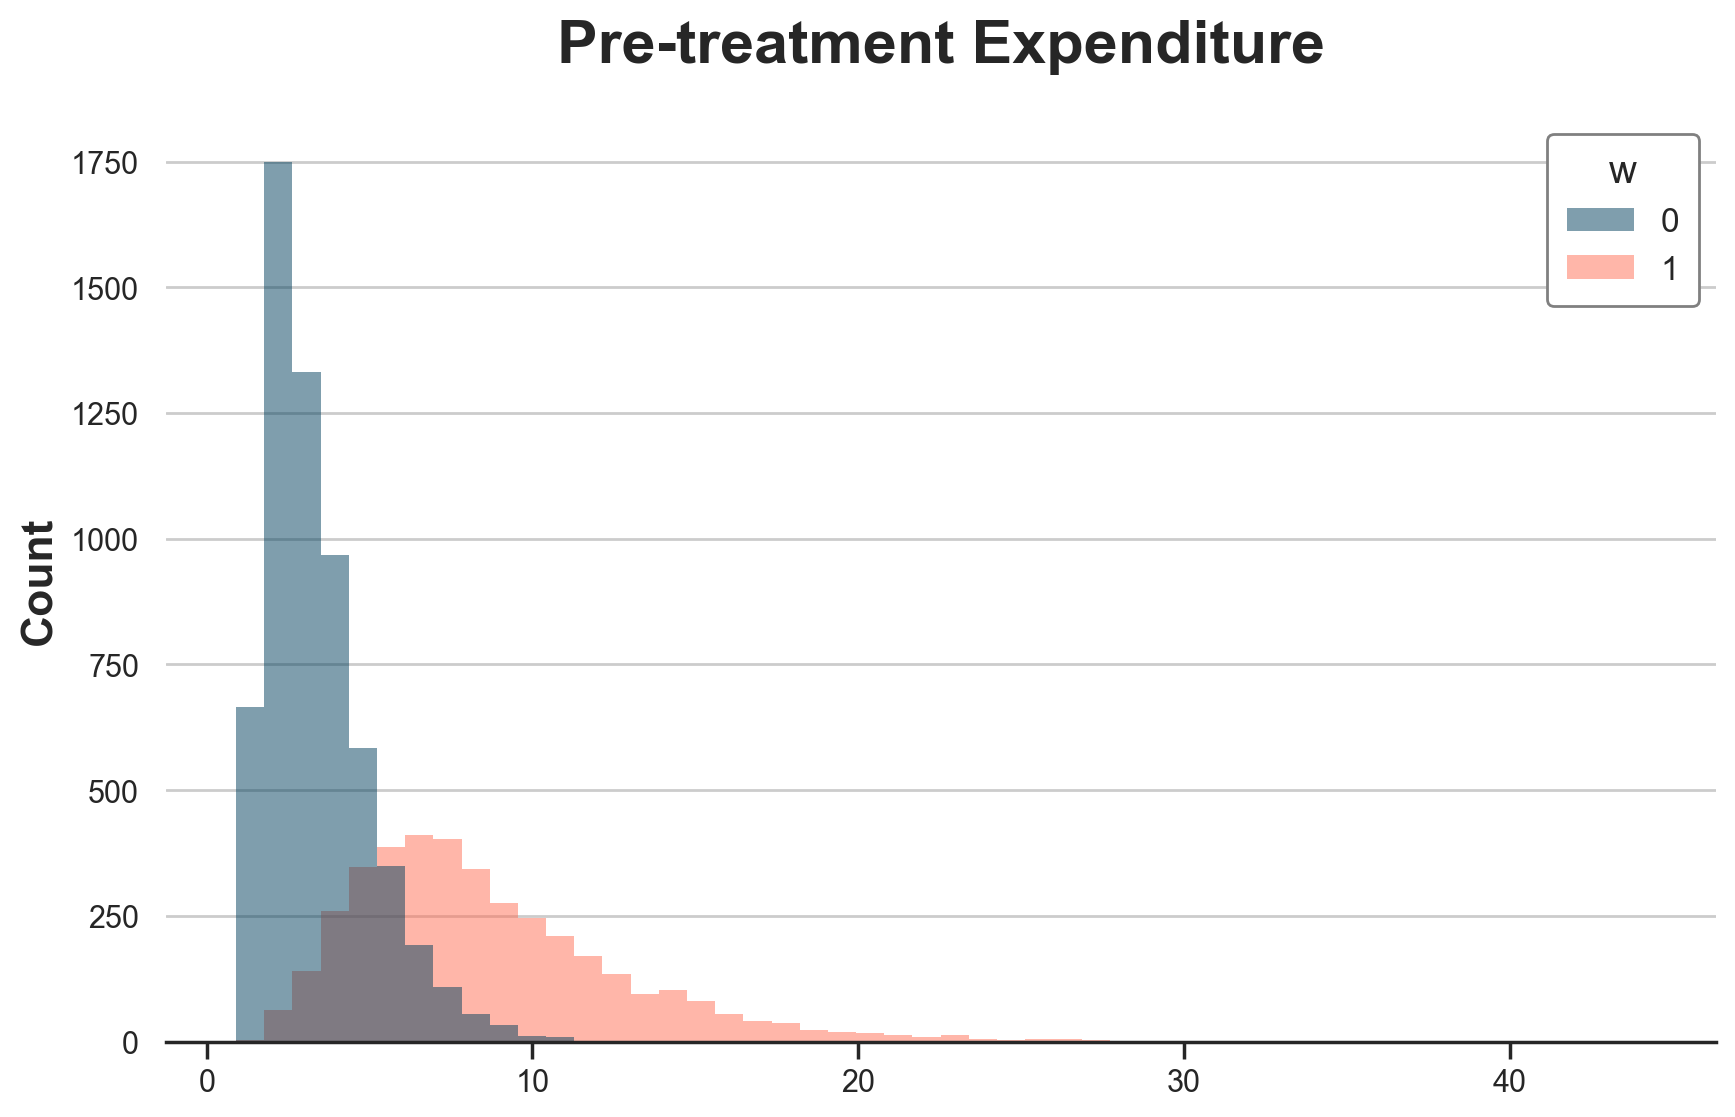

In [10]:
g = sns.histplot(data=df[df.t==0], x="y_w0", hue="w", bins=50);
g.set(xlabel="", title="Pre-treatment Expenditure");

Types are also reflected in the "true" propensity scores.

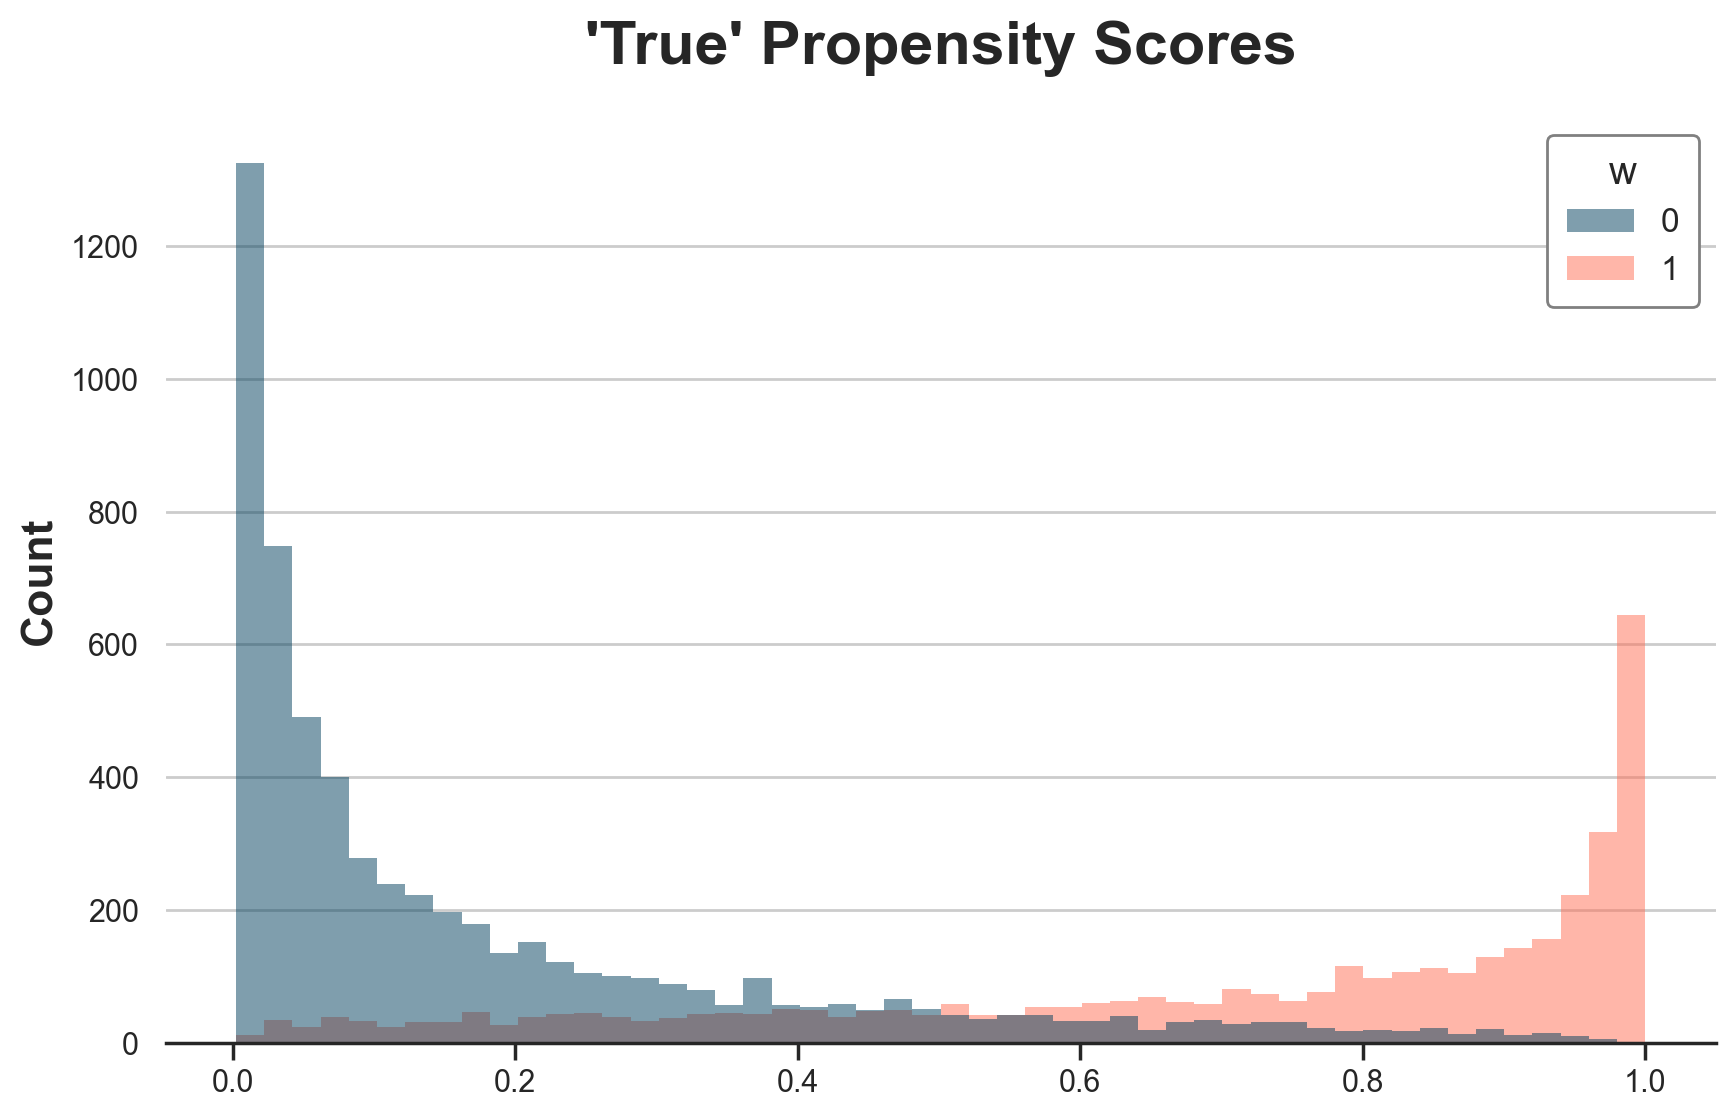

In [11]:
g = sns.histplot(data=dfw, x="e", hue="w", bins=50);
g.set(xlabel="", title="'True' Propensity Scores");

## Exploration

What does the data looks like? Let's plot the outcome distribution across treatment status and time periods. 

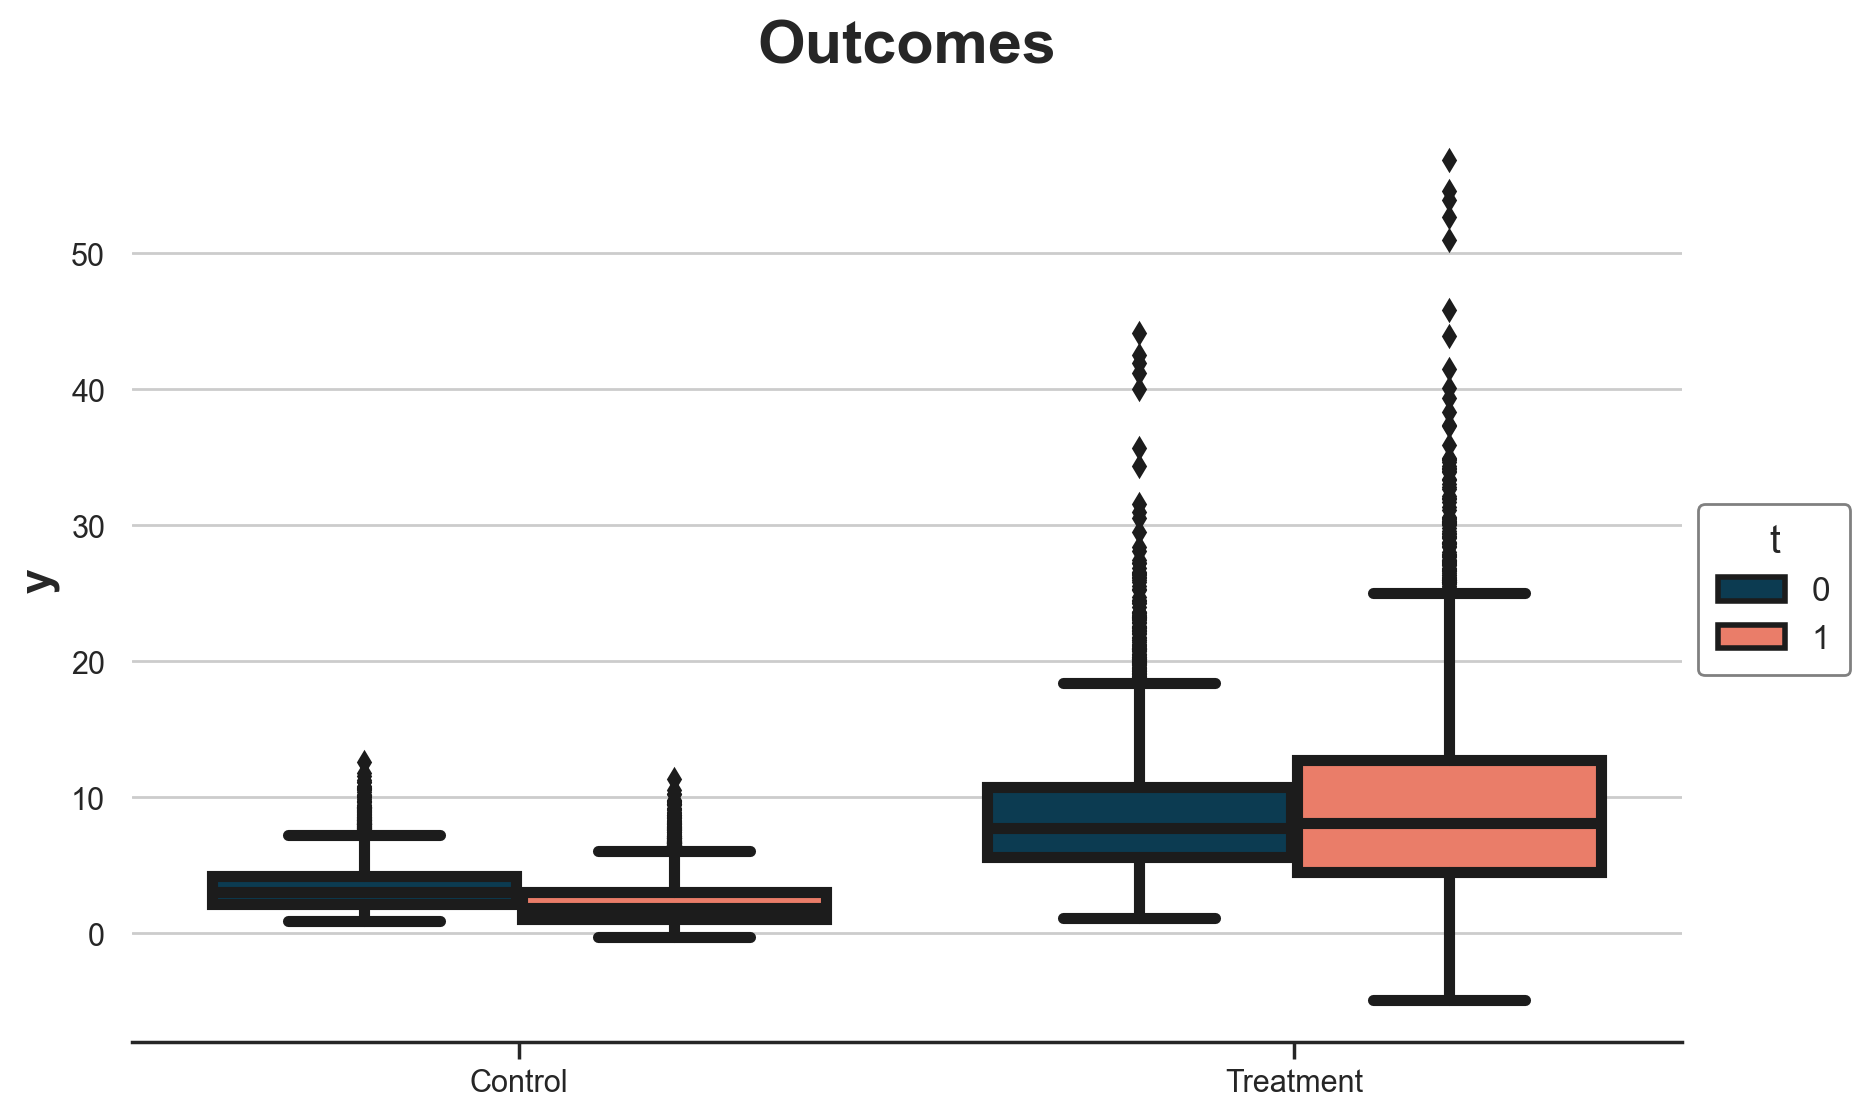

In [12]:
g = sns.boxplot(data=df, x="w", y="y", hue="t"); 
g.set(xlabel="", title="Outcomes", xticklabels=["Control", "Treatment"]);
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 0.6));

It seems that treated spend more than the control, and the pre-post difference for the control group is negative. 

## Difference-in-Differences

Before jumping to DiD, let's check treatment/control and before/after estimators.

### Treatment / Control

The post-treatment treatment/control average outcome difference is very far from any estimand of interest.

In [13]:
smf.ols("y_t1 ~ 1 + w", data=dfw).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.2393,0.057,39.510,0.000,2.128,2.350
w,6.9789,0.090,77.282,0.000,6.802,7.156


### Before / After

The treated before/after average outcome difference is fairly close to the ATT, but still off.

In [14]:
smf.ols("y ~ 1 + t", data=df[df.w == 1]).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,8.6691,0.091,95.293,0.000,8.491,8.847
t,0.5491,0.129,4.268,0.000,0.297,0.801


### Difference-in-Differences

As expected, the difference-in-differences estimator nails the ATT, with an estimate of exactly *1.69€*. 

In [15]:
smf.ols("y ~ 1 + t * w", data=df).fit(cov_type="cluster", cov_kwds={"groups": df.i}).summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,3.3782,0.021,164.162,0.000,3.338,3.419
t,-1.1389,0.004,-319.609,0.000,-1.146,-1.132
w,5.2909,0.074,71.815,0.000,5.147,5.435
t:w,1.6880,0.038,44.660,0.000,1.614,1.762


## DML

What about double machine learning? Let's start with the default nuisance models, `LogisticRegressionCV()` for the propensity model and `WeightedLassoCV()` for the outcome model. Note that this is far from an innocuous choice since our outcome model is linear and our propensity model is logit. We are assuming model misspecification away.

Our only observable is the pre-treatment outcome.

In [16]:
X = dfw[["y_t0"]]
w = dfw["w"]
y = dfw["y_t1"]

In [17]:
%%capture
model_cate = CausalForestDML(discrete_treatment=True).fit(X=X, T=w, Y=y)

Let's print ATE, ATT, and ATC. They are wildly off.

In [18]:
def print_model_estimates(model):
    print(f"ATE: {model.ate_[0]:.2f} ± {2 * model.ate_stderr_[0]:.2f}")
    print(f"ATT: {model.att_(T=1)[0]:.2f} ± {2 * model.att_stderr_(T=1)[0]:.2f}")
    print(f"ATT: {model.att_(T=0)[0]:.2f} ± {2 * model.att_stderr_(T=0)[0]:.2f}")

In [19]:
print_model_estimates(model_cate)

ATE: 28.22 ± 6.47
ATT: 74.89 ± 10.30
ATT: -2.44 ± 1.02


What's the problem? Let's plot the estimated effects against the true ones.

In [20]:
def plot_model_estimates(model, dfw, force45=False):
    dfw["tau_hat"] = model.effect(X)
    fig, ax = plt.subplots()
    sns.scatterplot(data=dfw, x="tau", y="tau_hat", ax=ax);
    lspace = np.linspace(dfw.tau.min(), dfw.tau.max(), 1000)
    if force45:
        lspace = np.linspace(dfw.tau_hat.min(), dfw.tau_hat.max(), 1000)
    g = sns.lineplot(x=lspace, y=lspace, c="C1", lw=3, ax=ax);
    g.set(xlabel="True Effects", ylabel="Estimated Effects", title="CATE Model Performance")

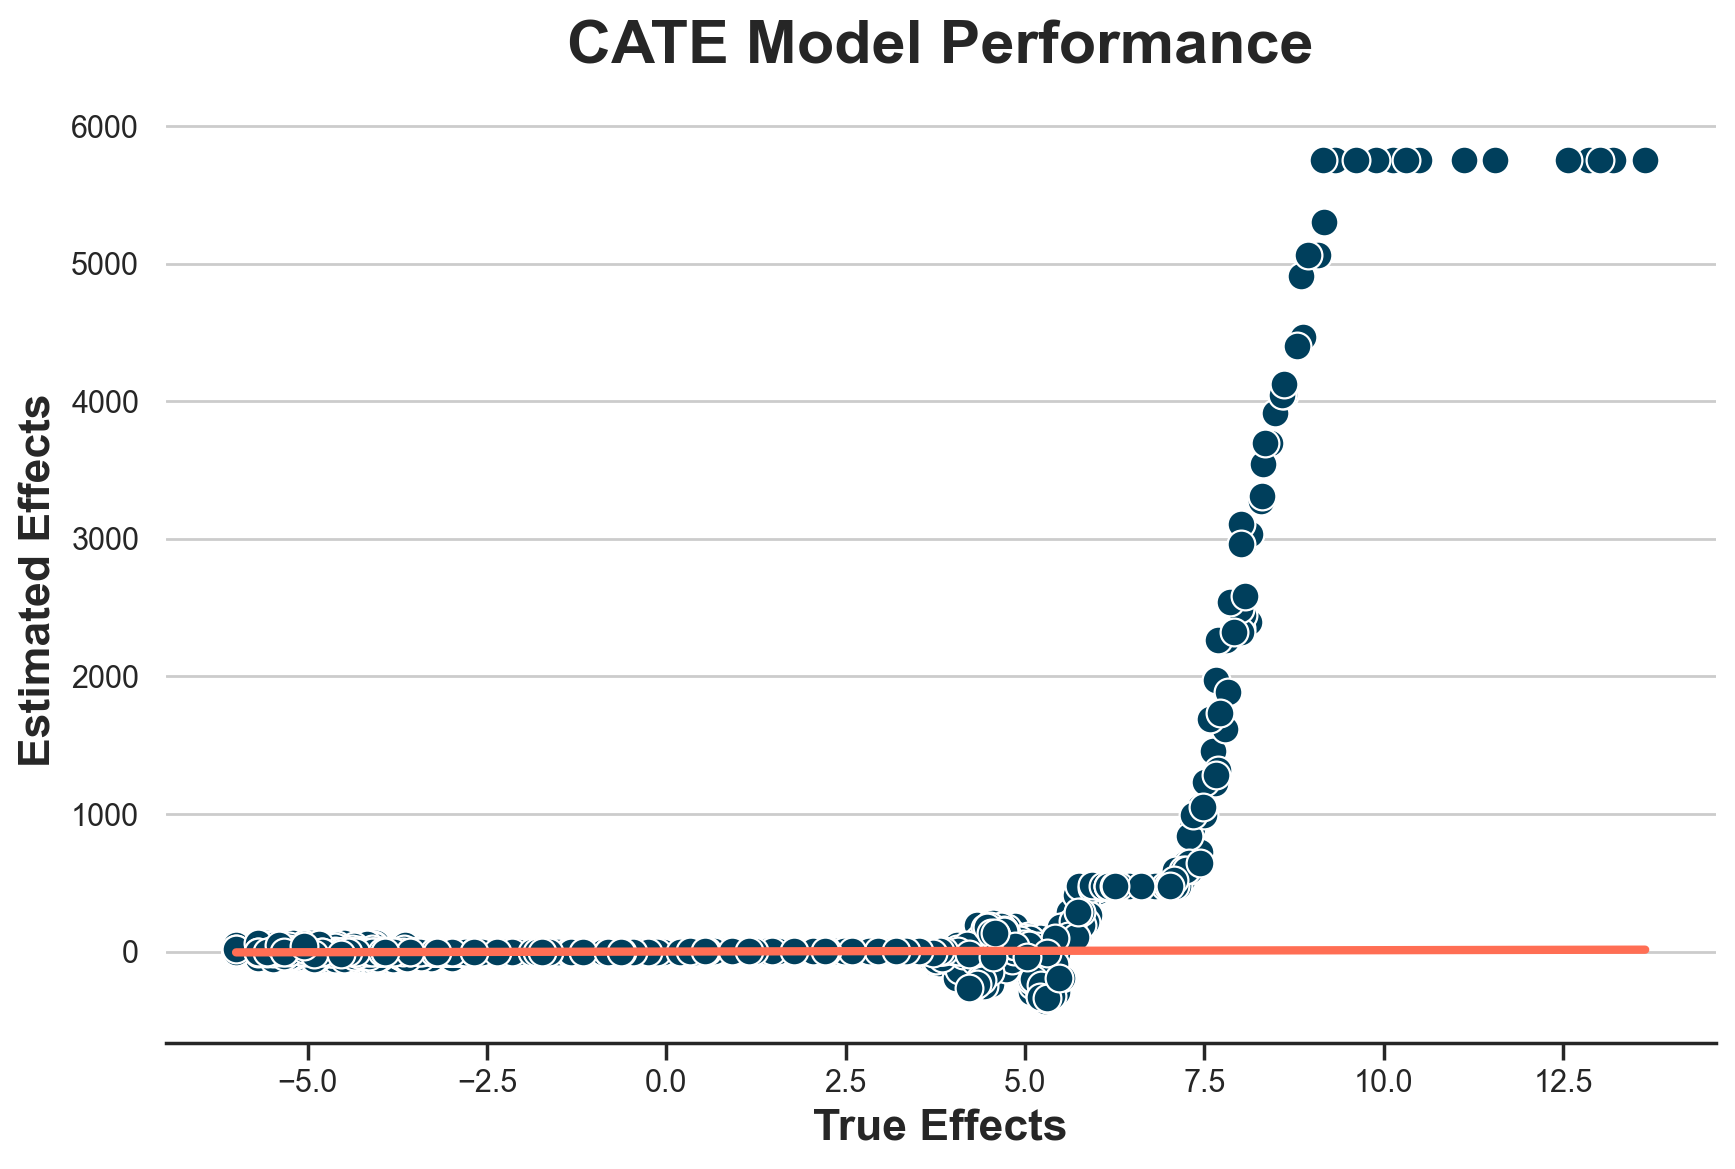

In [21]:
plot_model_estimates(model_cate, dfw)

It seems that we correctly estimate treatment effects for individuals with effects lower than 4.5. And then gradually we wander astray.

Is it a problem of propensity scores? Yes and no. We are estimating them correctly, but there are too many zeroes and ones. 

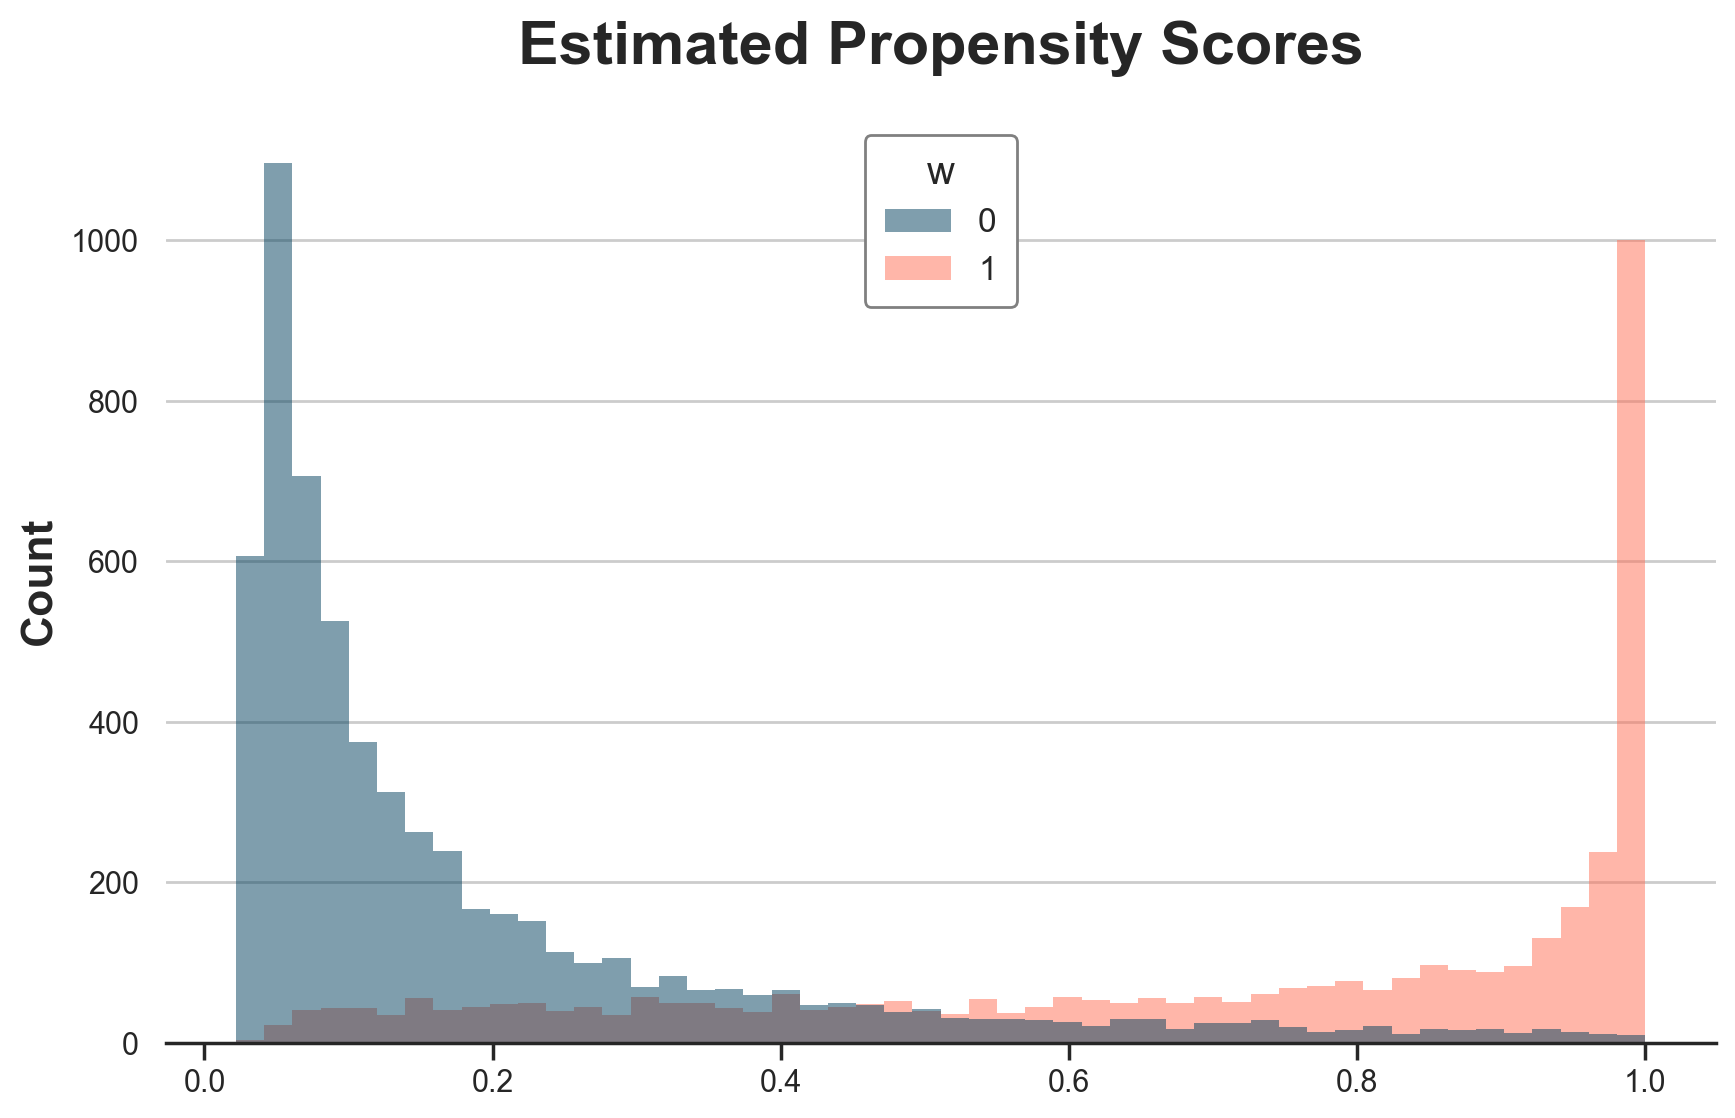

In [22]:
dfw["w_hat"] = LogisticRegressionCV().fit(X=X, y=w).predict_proba(X)[:,1]
g = sns.histplot(data=dfw, x="w_hat", hue="w", bins=50);
g.set(xlabel="", title="Estimated Propensity Scores");

### Restrict Sample to Overlap

As a first tentative solution, let's restrict the sample to the overlapping sample, in terms of estimated propensity scores.

In [23]:
w_min = np.maximum(dfw.loc[w==1, "w_hat"].min(), dfw.loc[w==0, "w_hat"].min())
w_max = np.minimum(dfw.loc[w==1, "w_hat"].max(), dfw.loc[w==0, "w_hat"].max())

In [24]:
df_overlap = dfw[(dfw.w_hat > w_min) & (dfw.w_hat < w_max)]
# ATE
ate_overlap = model_cate.ate_inference(X=df_overlap[["y_t0"]])
print(f"ATE: {ate_overlap.mean_point:.2f} ± {2 * ate_overlap.stderr_mean:.2f}")
# ATT
att_overlap = model_cate.ate_inference(X=df_overlap.loc[df_overlap.w==1, ["y_t0"]])
print(f"ATT: {att_overlap.mean_point:.2f} ± {2 * att_overlap.stderr_mean:.2f}")
# ATC
atc_overlap = model_cate.ate_inference(X=df_overlap.loc[df_overlap.w==0, ["y_t0"]])
print(f"ATE: {atc_overlap.mean_point:.2f} ± {2 * atc_overlap.stderr_mean:.2f}")

ATE: -1.15 ± 15.11
ATT: 0.65 ± 12.59
ATE: -2.14 ± 16.33


### Winsorize Propensities

What if instead we winsorized propensity scores?

Let's write a wrapper around our propensity model `LogisticRegressionCV()`.

In [25]:
class WinsorizedLogisticRegressionCV():
    """Wrapper around LogisticRegressionCV."""

    def __init__(self, p_winsor: float = 0.1):
        self.model = LogisticRegressionCV()
        self.p_winsor = p_winsor

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        p = self.model.predict_proba(X)
        return np.maximum(np.minimum(p, 1 - self.p_winsor), self.p_winsor)

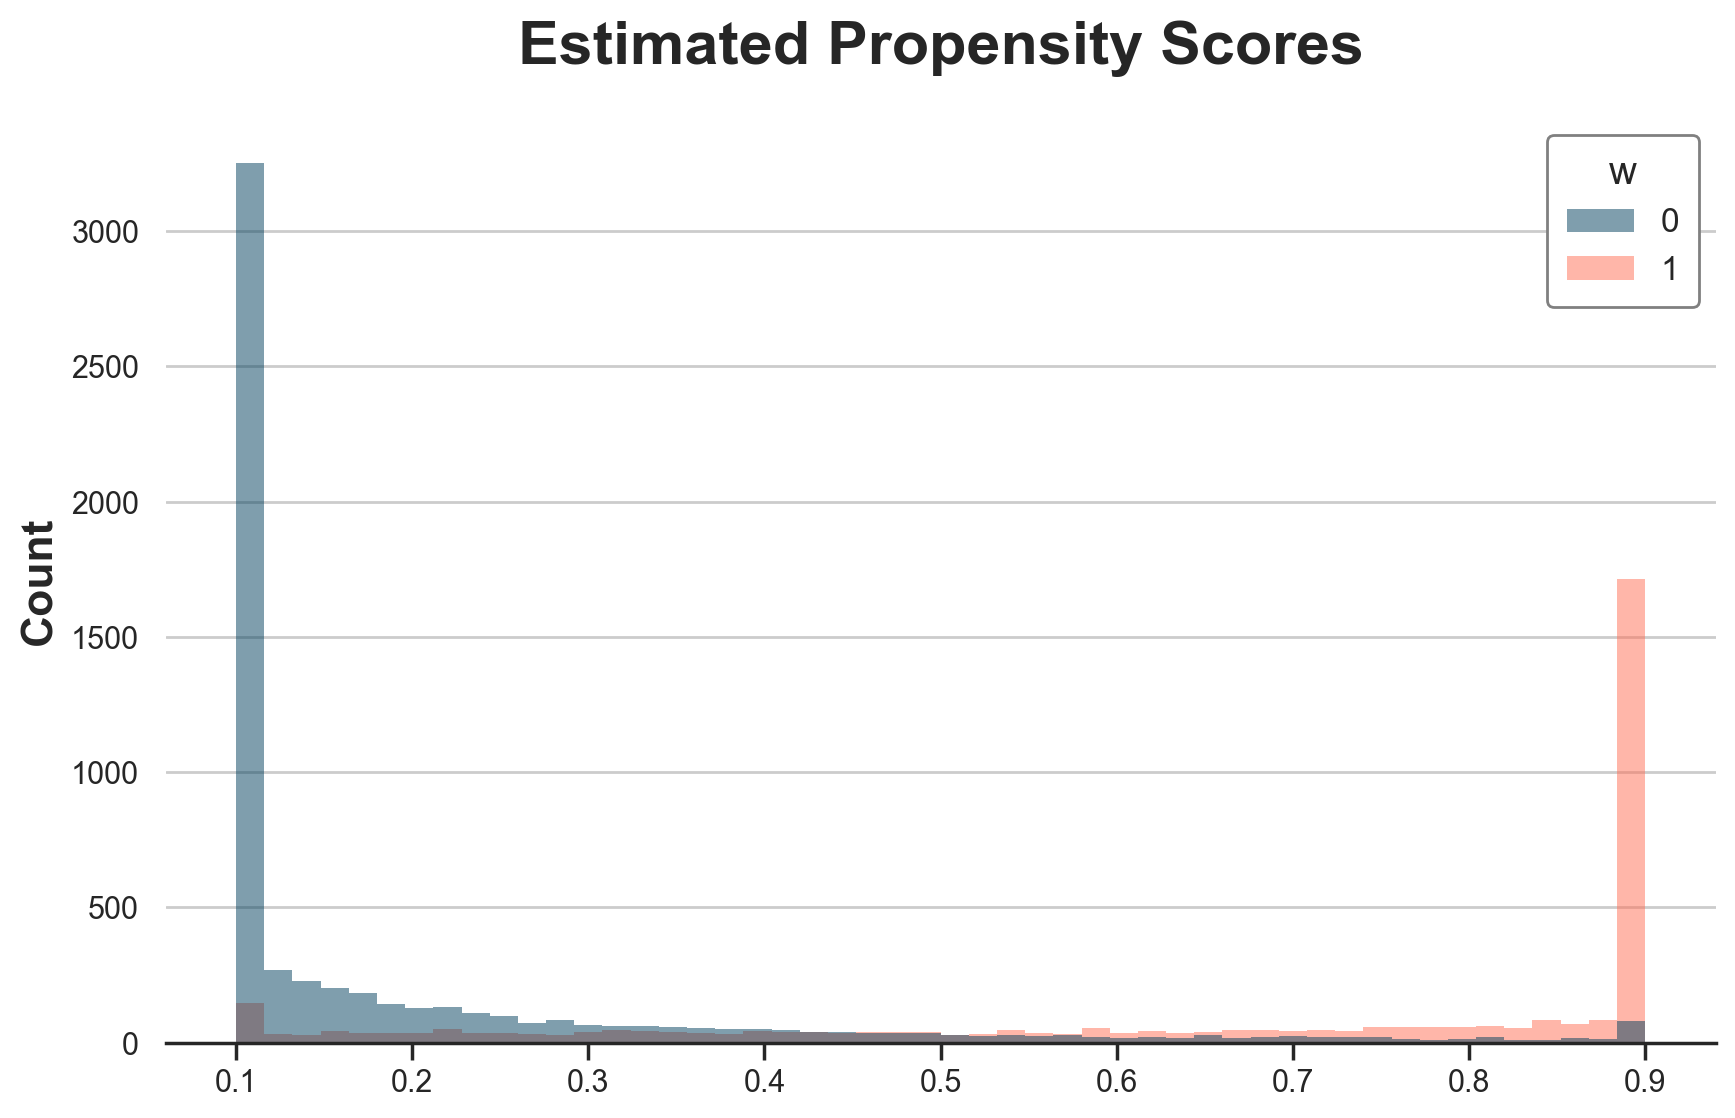

In [26]:
# Overlap
dfw["w_hat_trimmed"] = WinsorizedLogisticRegressionCV().fit(X=X, y=w).predict_proba(X)[:,1]
g = sns.histplot(data=dfw, x="w_hat_trimmed", hue="w", bins=50);
g.set(title="Estimated Propensity Scores", xlabel="");

In [27]:
%%capture
model_trimmed = CausalForestDML(model_t=WinsorizedLogisticRegressionCV(), discrete_treatment=True).fit(X=X, T=w, Y=y)

In [28]:
print_model_estimates(model_trimmed)

ATE: -0.77 ± 0.06
ATT: 0.99 ± 0.07
ATT: -2.04 ± 0.06


The estimated coefficients are fairly close to the true ones: *-0.77€* for the ATE (true is *-0.72€*), *0.99€* for the ATT (true is *1.69€*), and *-2.04€* for the ATC (true is *-2.28€*).

If anything, it seems we have some bias towards zero. Let's plot the estimated effects against the true ones.

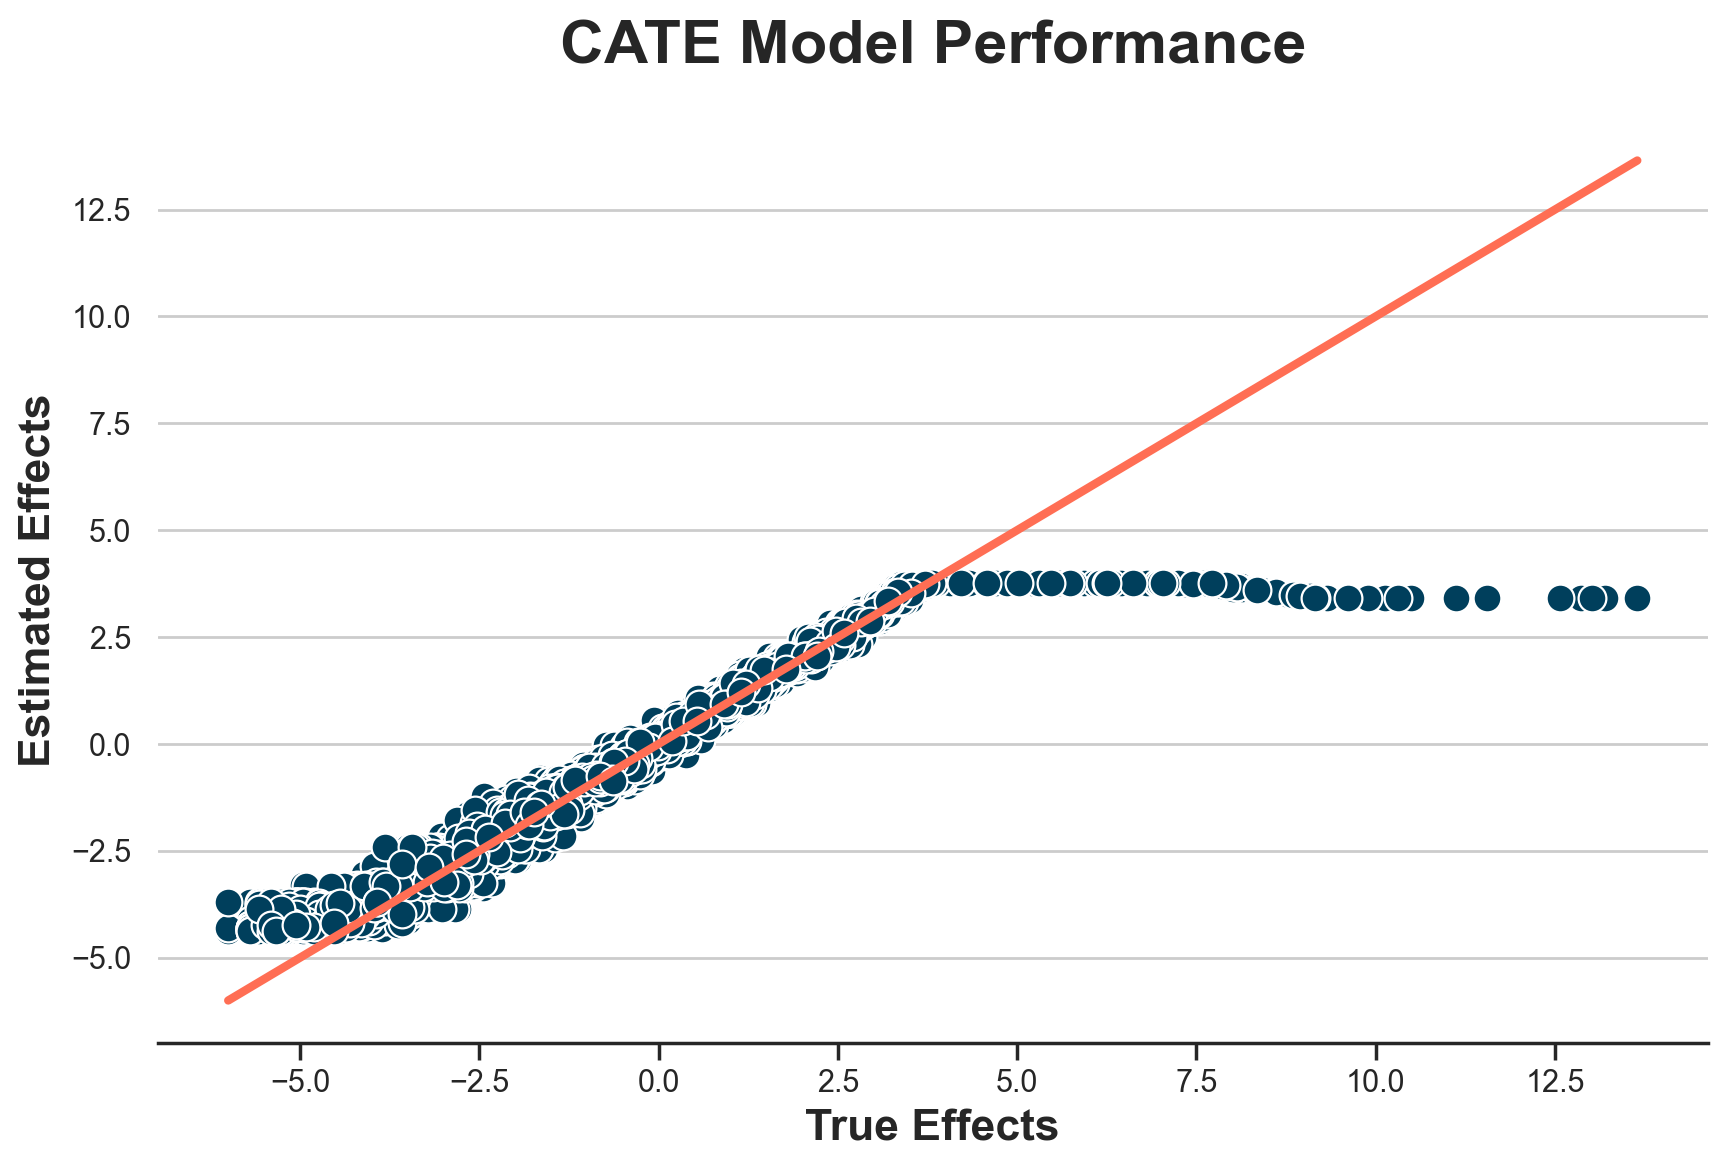

In [29]:
plot_model_estimates(model_trimmed, dfw)

It seems that we are only able to estimate treatment effects between *-4.5* and *+3.5*.

Weird? Not at all. It totally makes sense, since this is the area in which we have overlap in terms of treatment effects. In the plot below I plot (again) the distribution of "true" Treatment effects across treatment groups. I highlight the range *-4.5* to *+3.5* with vertical lines.

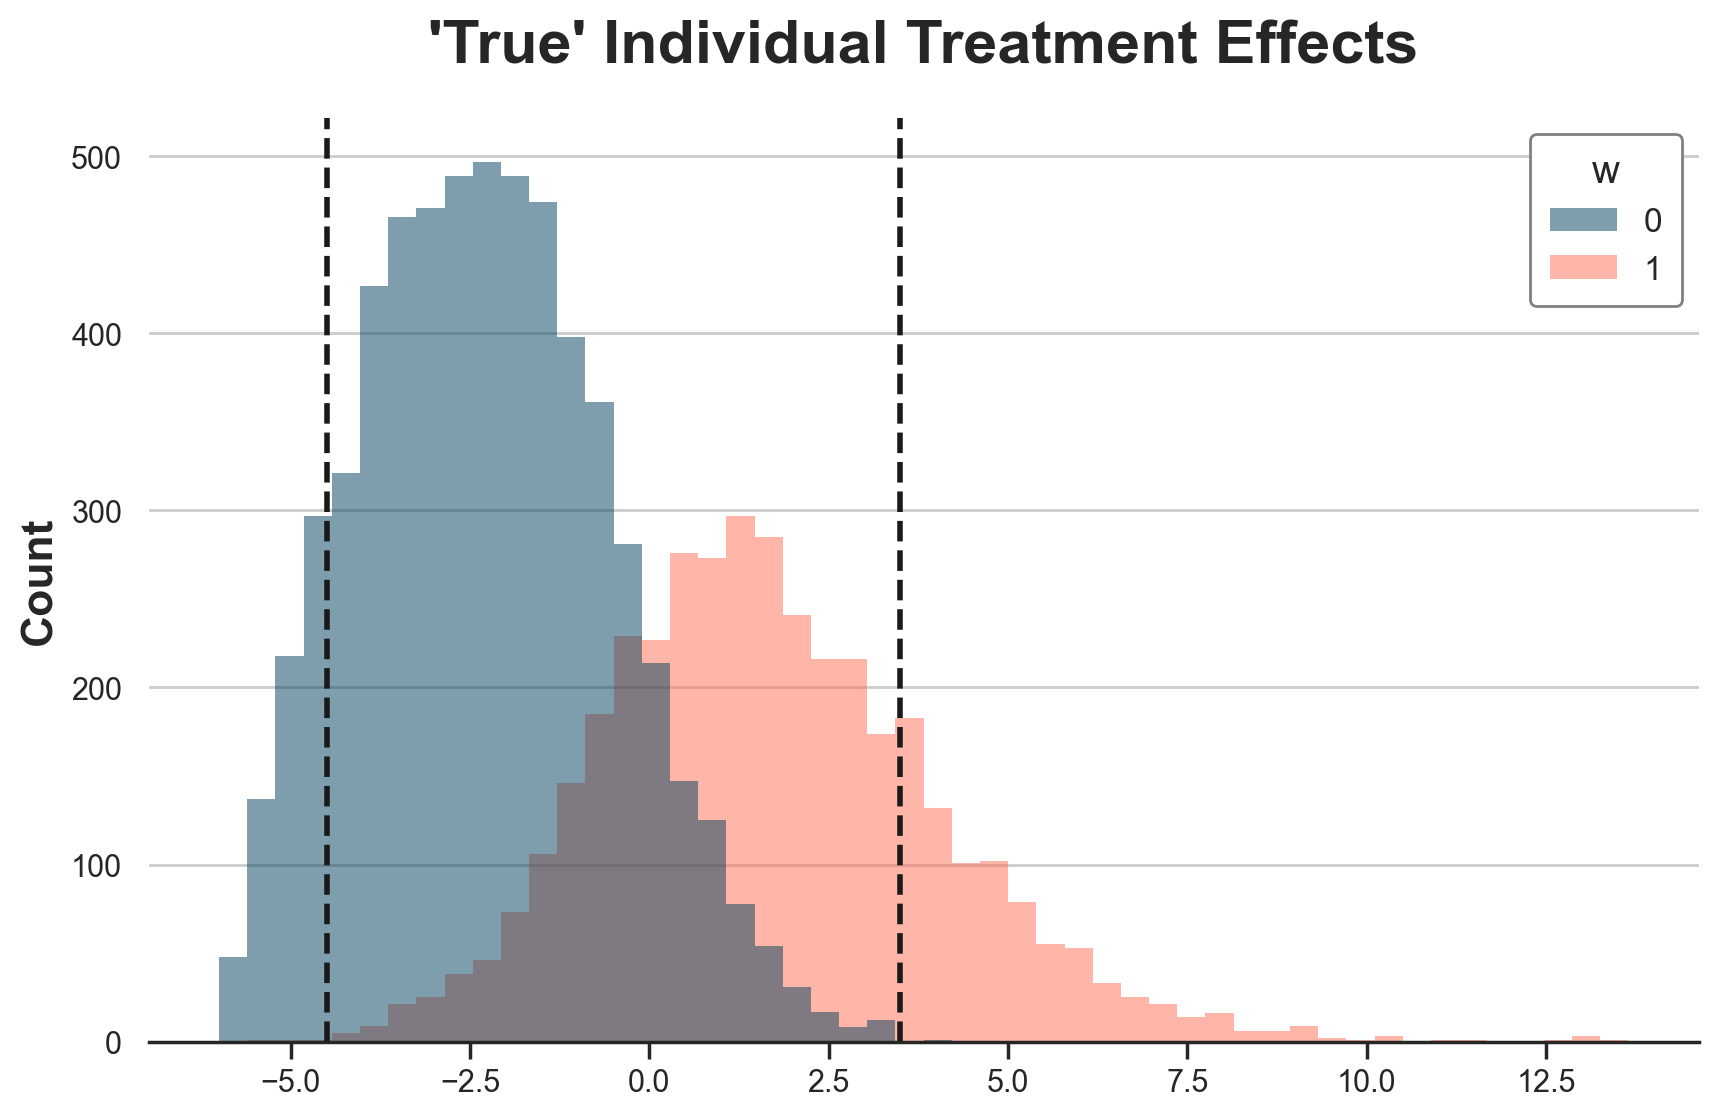

In [30]:
fig, ax = plt.subplots()
g = sns.histplot(data=df[df.t==0], x="tau", hue="w", bins=50);
g.set(title="'True' Individual Treatment Effects", xlabel="")
ax.axvline(x=3.5, c="k", lw=2, ls="--");
ax.axvline(x=-4.5, c="k", lw=2, ls="--");

### First differences as outcomes

What if we use first differences as outcomes?

In [31]:
X = dfw[["y_t0"]]
w = dfw["w"]
y_diff = dfw["y_t1"] - dfw["y_t0"]

In [32]:
%%capture
model_diff = CausalForestDML(discrete_treatment=True).fit(X=X, T=w, Y=y_diff)

Estimates are terrible without winsorizing.

In [33]:
print_model_estimates(model_diff)

ATE: 32.42 ± 8.03
ATT: 86.53 ± 12.78
ATT: -2.62 ± 1.15


Let's try with winsorization.

In [34]:
%%capture
model_diff = CausalForestDML(model_t=WinsorizedLogisticRegressionCV(), discrete_treatment=True).fit(X=X, T=w, Y=y_diff)

Estimates are almost exactly identical. It looks like differences in outcomes are not changing much.

In [35]:
print_model_estimates(model_diff)

ATE: -0.78 ± 0.06
ATT: 0.99 ± 0.07
ATT: -2.04 ± 0.06


Do they at least help in estimating individual treatment effects? Doesn't look like

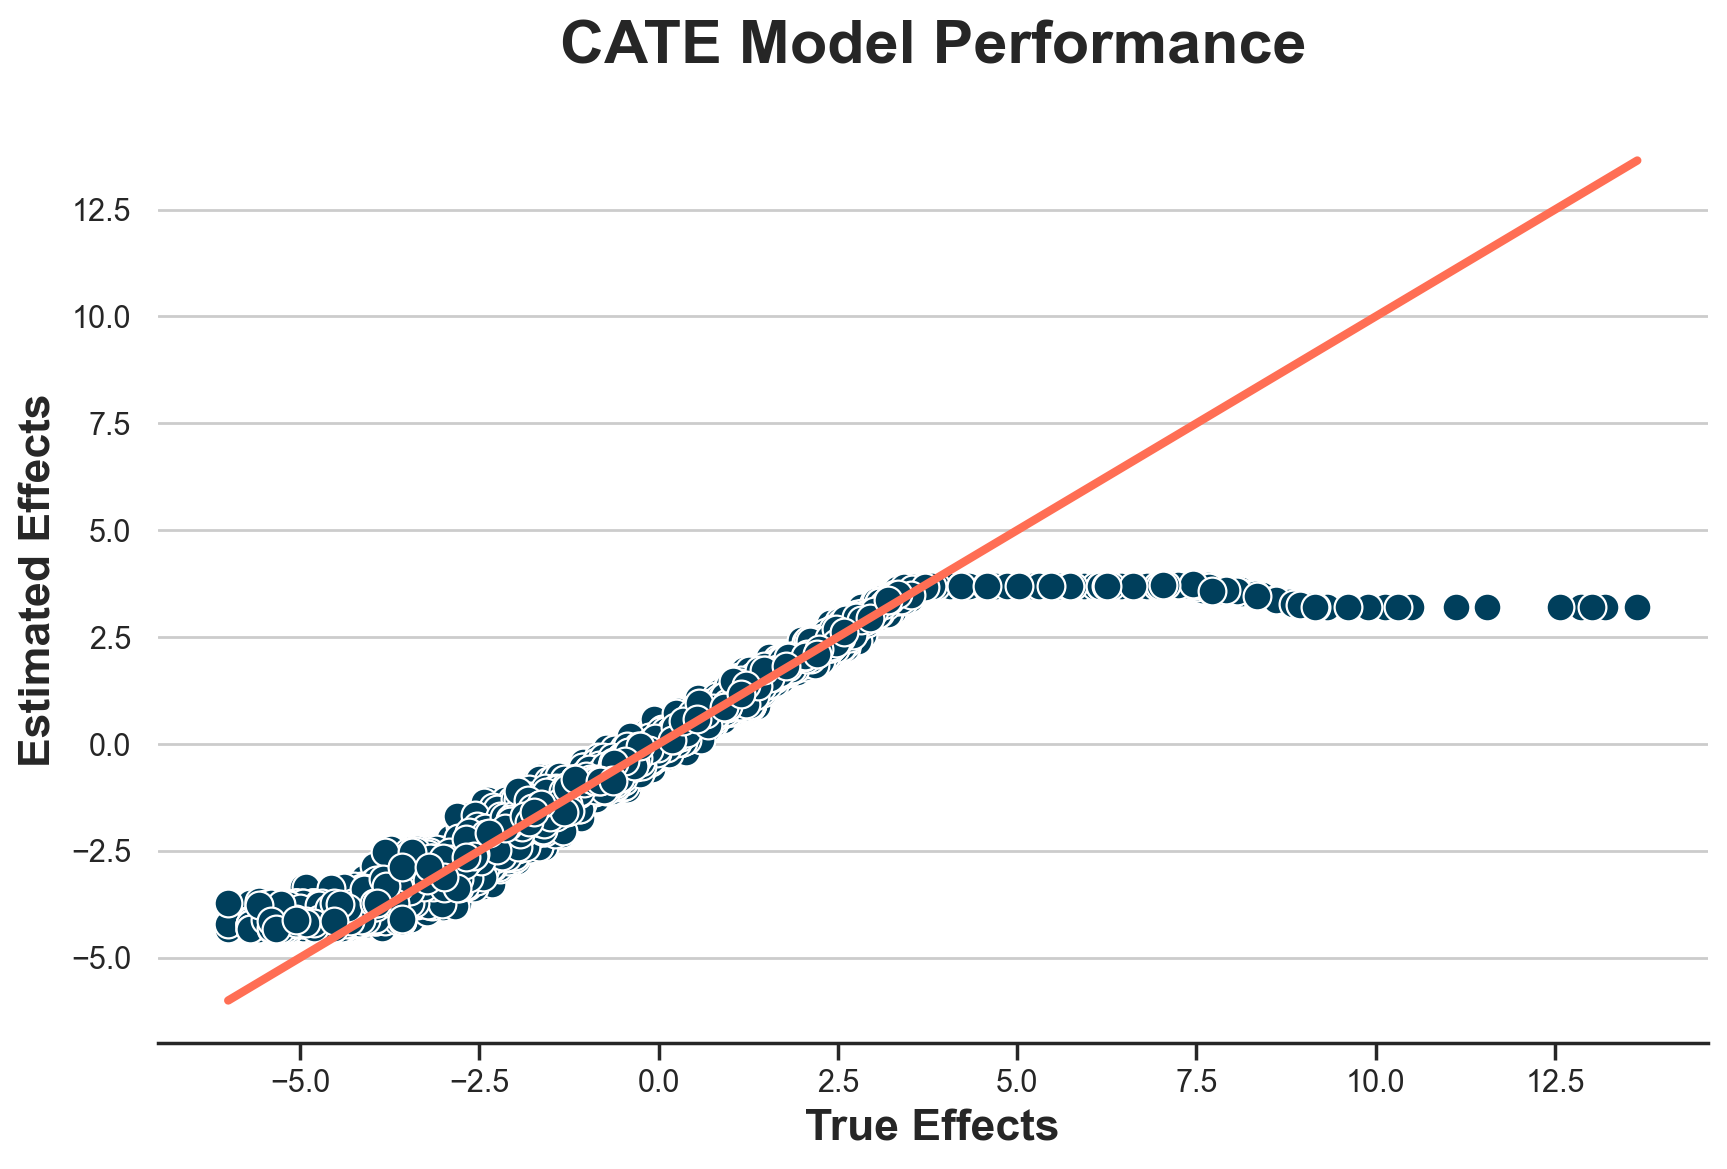

In [36]:
plot_model_estimates(model_diff, dfw)

### Non-parametric Nuisances

Ok, in the previous section we were a bit cheating. What's the point of advocating non-parametric methods if you use linear regression for a linear model and logistic regression for a logistic model?

Let's repeat the exercise but using boosted regression trees, from the [lightGBM](https://lightgbm.readthedocs.io/en/stable/) package.

In [37]:
%%capture
model_t = LGBMClassifier(n_estimators=500)
model_y = LGBMRegressor(n_estimators=500)
model_lgbm = CausalForestDML(model_t=model_t, model_y=model_y, discrete_treatment=True).fit(X=X, T=w, Y=y)

In [38]:
print_model_estimates(model_lgbm)

ATE: 1.13 ± 1.36
ATT: 1.75 ± 0.38
ATT: 0.88 ± 1.75


As before, without trimming, we get very weird results. Let's add propensity score trimming.

In [39]:
class WinsorizedLGBMClassifier:
    """Wrapper around LGBMClassifier."""

    def __init__(self, p_winsor:float = 0.01, *args, **kwargs):
        self.model = LGBMClassifier(*args, **kwargs)
        self.p_winsor = p_winsor

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X, clip_p=0.025):
        p = self.model.predict_proba(X)
        return np.maximum(np.minimum(p, 1 - self.p_winsor), self.p_winsor)

First, let's plot the estimated propensity scores.

In [40]:
%%capture
dfw["w_hat_trimmed"] = WinsorizedLGBMClassifier(n_estimators=500).fit(X=X, y=w).predict_proba(X)[:,1]

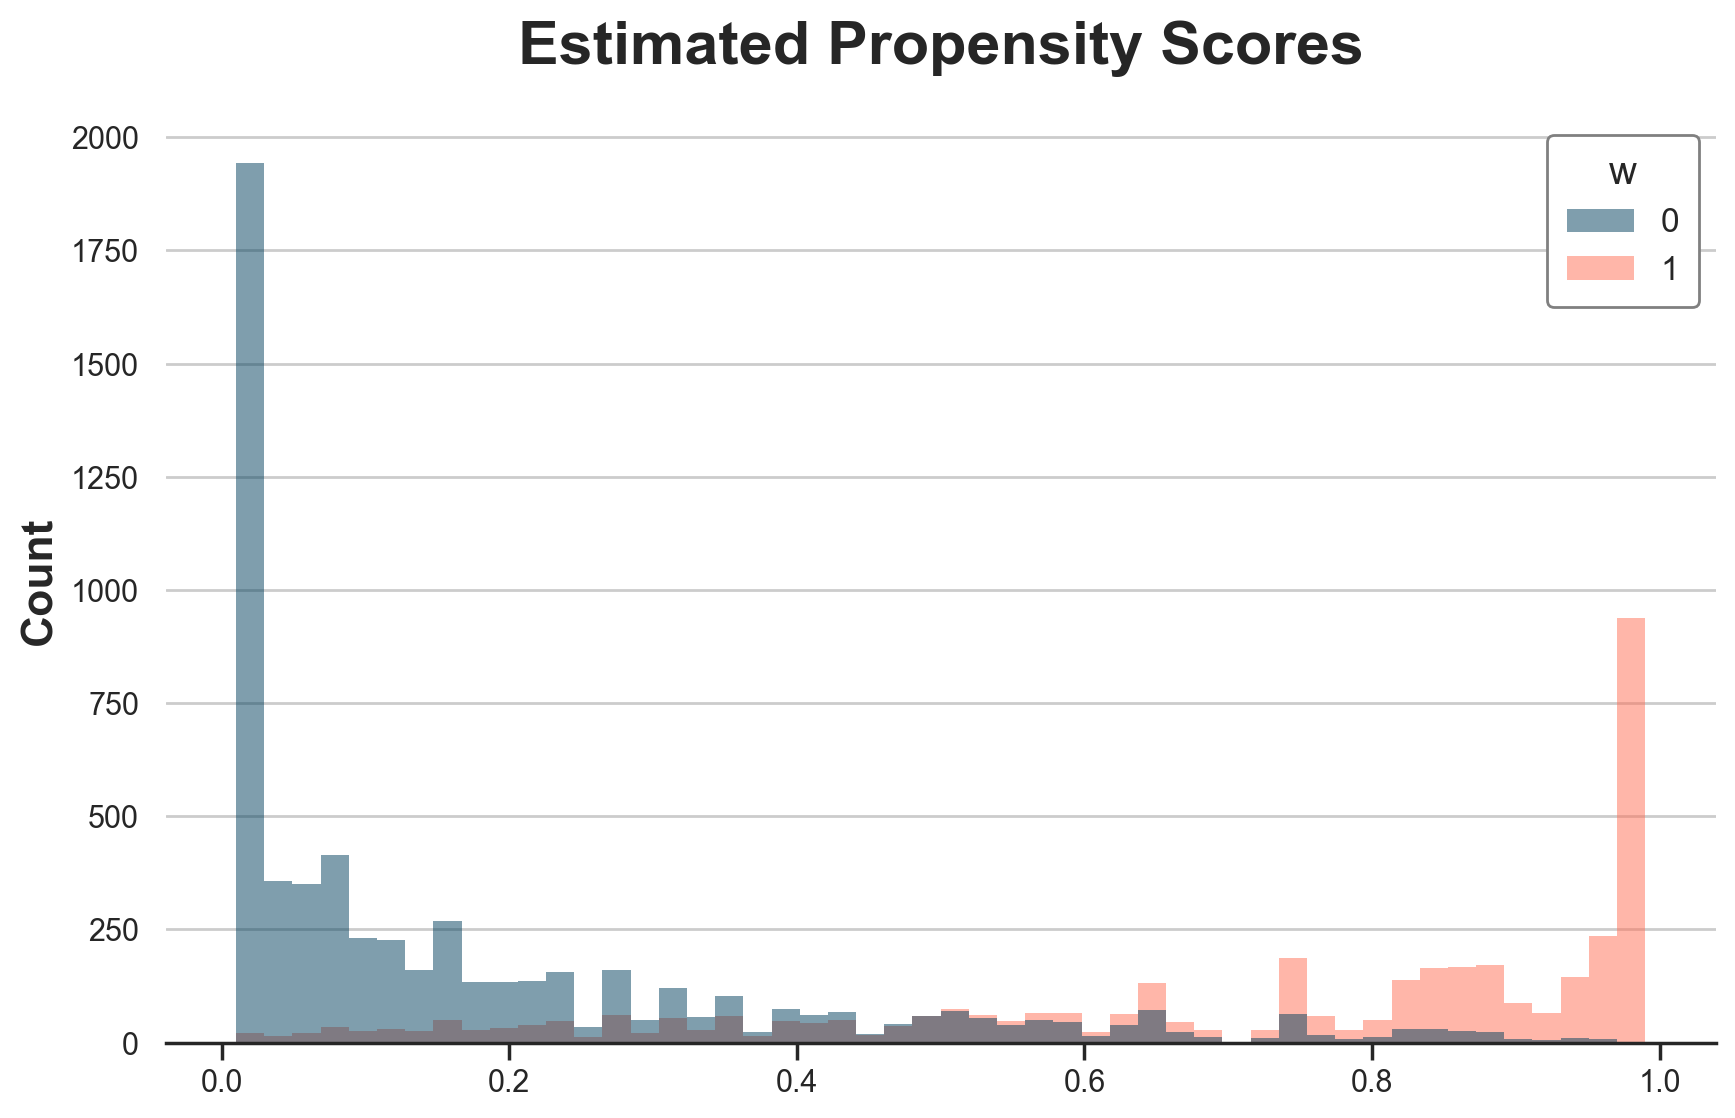

In [41]:
# Overlap
g = sns.histplot(data=dfw, x="w_hat_trimmed", hue="w", bins=50);
g.set(title="Estimated Propensity Scores", xlabel="");

The estimated propensity scores are much more "binned" than their logistic regression equivalent, as expected from a forest method.

In [42]:
%%capture
model_t = WinsorizedLGBMClassifier(n_estimators=500)
model_y = LGBMRegressor(n_estimators=500)
model_lgbm_trimmed = CausalForestDML(model_t=model_t, model_y=model_y, discrete_treatment=True).fit(X=X, T=w, Y=y)

In [43]:
print_model_estimates(model_lgbm_trimmed)

ATE: -0.72 ± 0.21
ATT: 1.42 ± 0.34
ATT: -2.15 ± 0.27


The estimated coefficients are extremely close to the true ones: true ATE is *-0.72€*, true ATT is *1.69€*, true ATC is *-2.28€*.

We can plot the true against the estimated treatment effects.

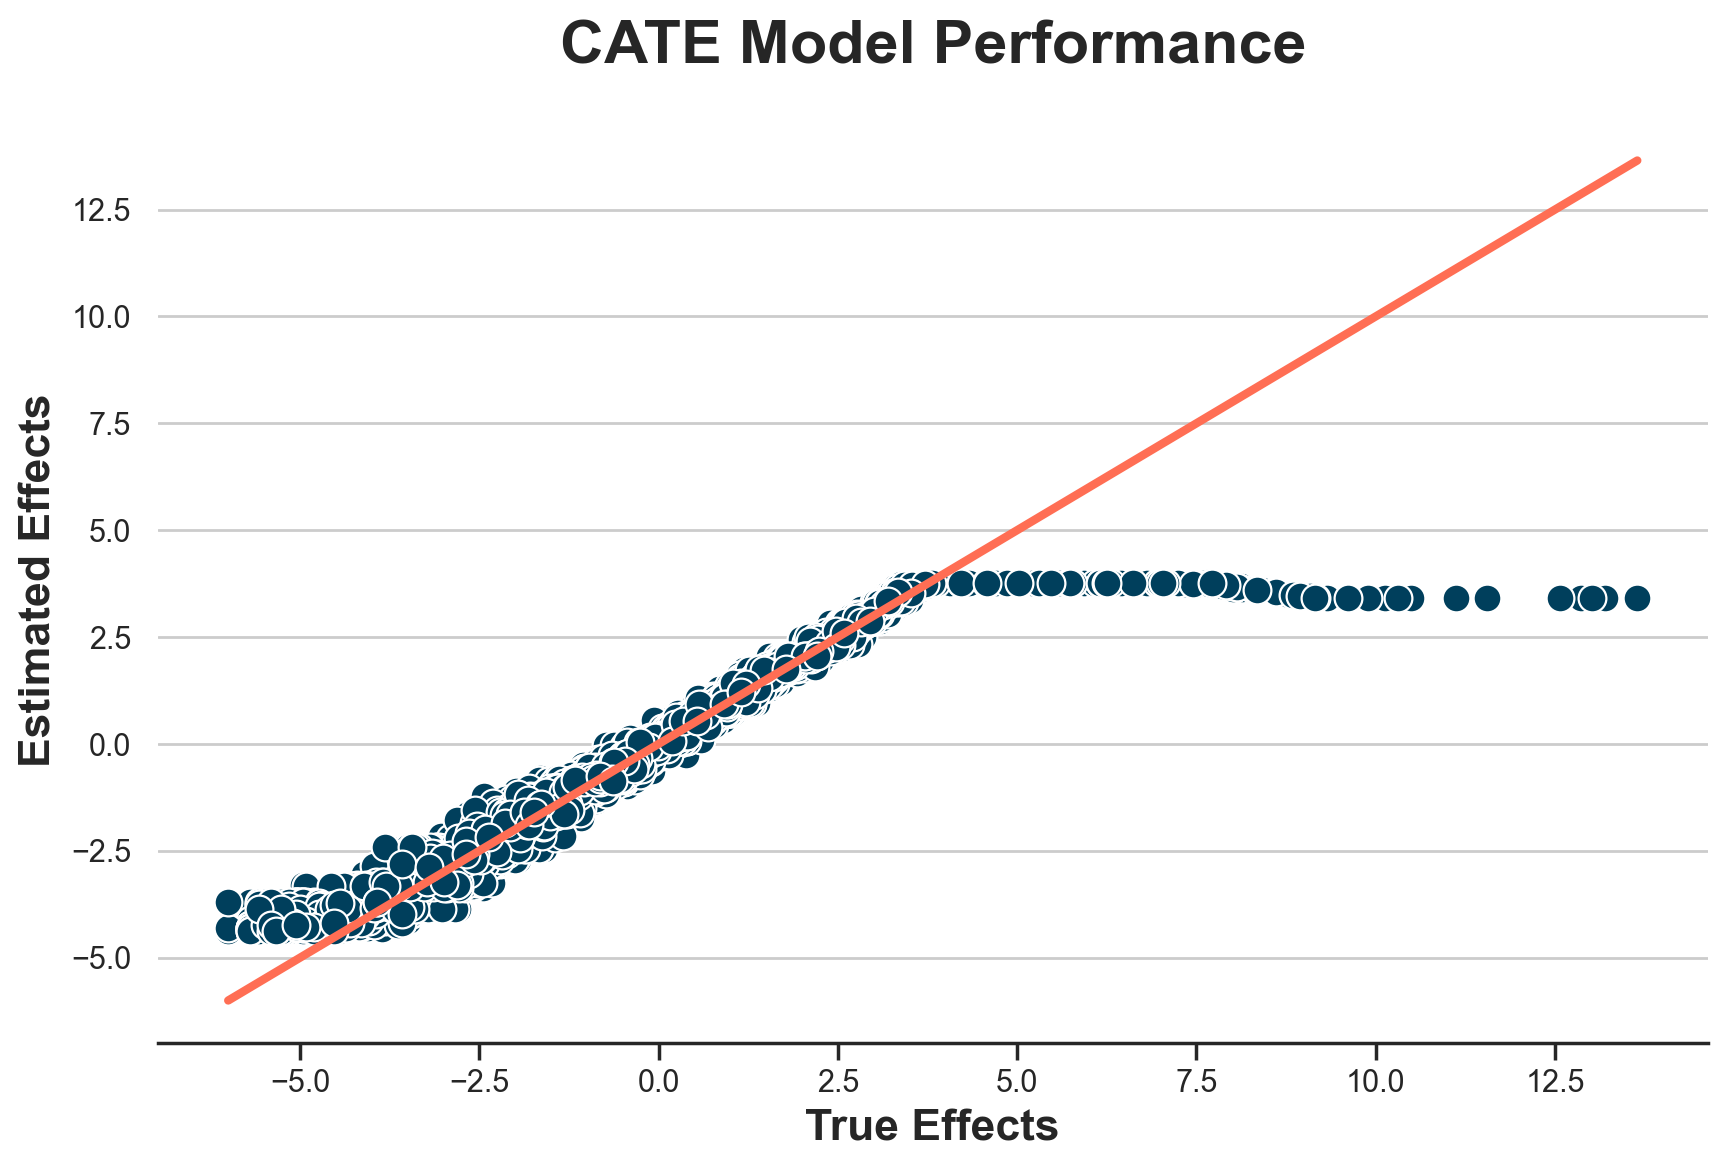

In [44]:
plot_model_estimates(model_trimmed, dfw)

### How much winsorizing?

What exactly is the effect of trimming? Let's plot the estimated ATE, ATT, and ATC for different winsorizing thresholds, from 0, no winsorizing, to 0.5, all predicted probabilities are 0.5.

In [45]:
%%capture
df_estimates = pd.DataFrame()
for p_winsor in np.linspace(0.01, 0.5, 45):
    model_t = WinsorizedLogisticRegressionCV(p_winsor=p_winsor)
    model_trimmed = CausalForestDML(model_t=model_t, discrete_treatment=True).fit(X=X, T=w, Y=y)
    temp = pd.DataFrame({
        "p_winsor": [p_winsor],
        "ate": model_trimmed.ate_,
        "att": model_trimmed.att_(T=1),
        "atc": model_trimmed.att_(T=0),
    })
    df_estimates = pd.concat([df_estimates, temp], ignore_index=True)

It looks like winsorizing biases the estimates towards zero. The less we winsorize, the closer we get to the true values... until we hit a threshold where we stop having overlap and estimates start jumping around.

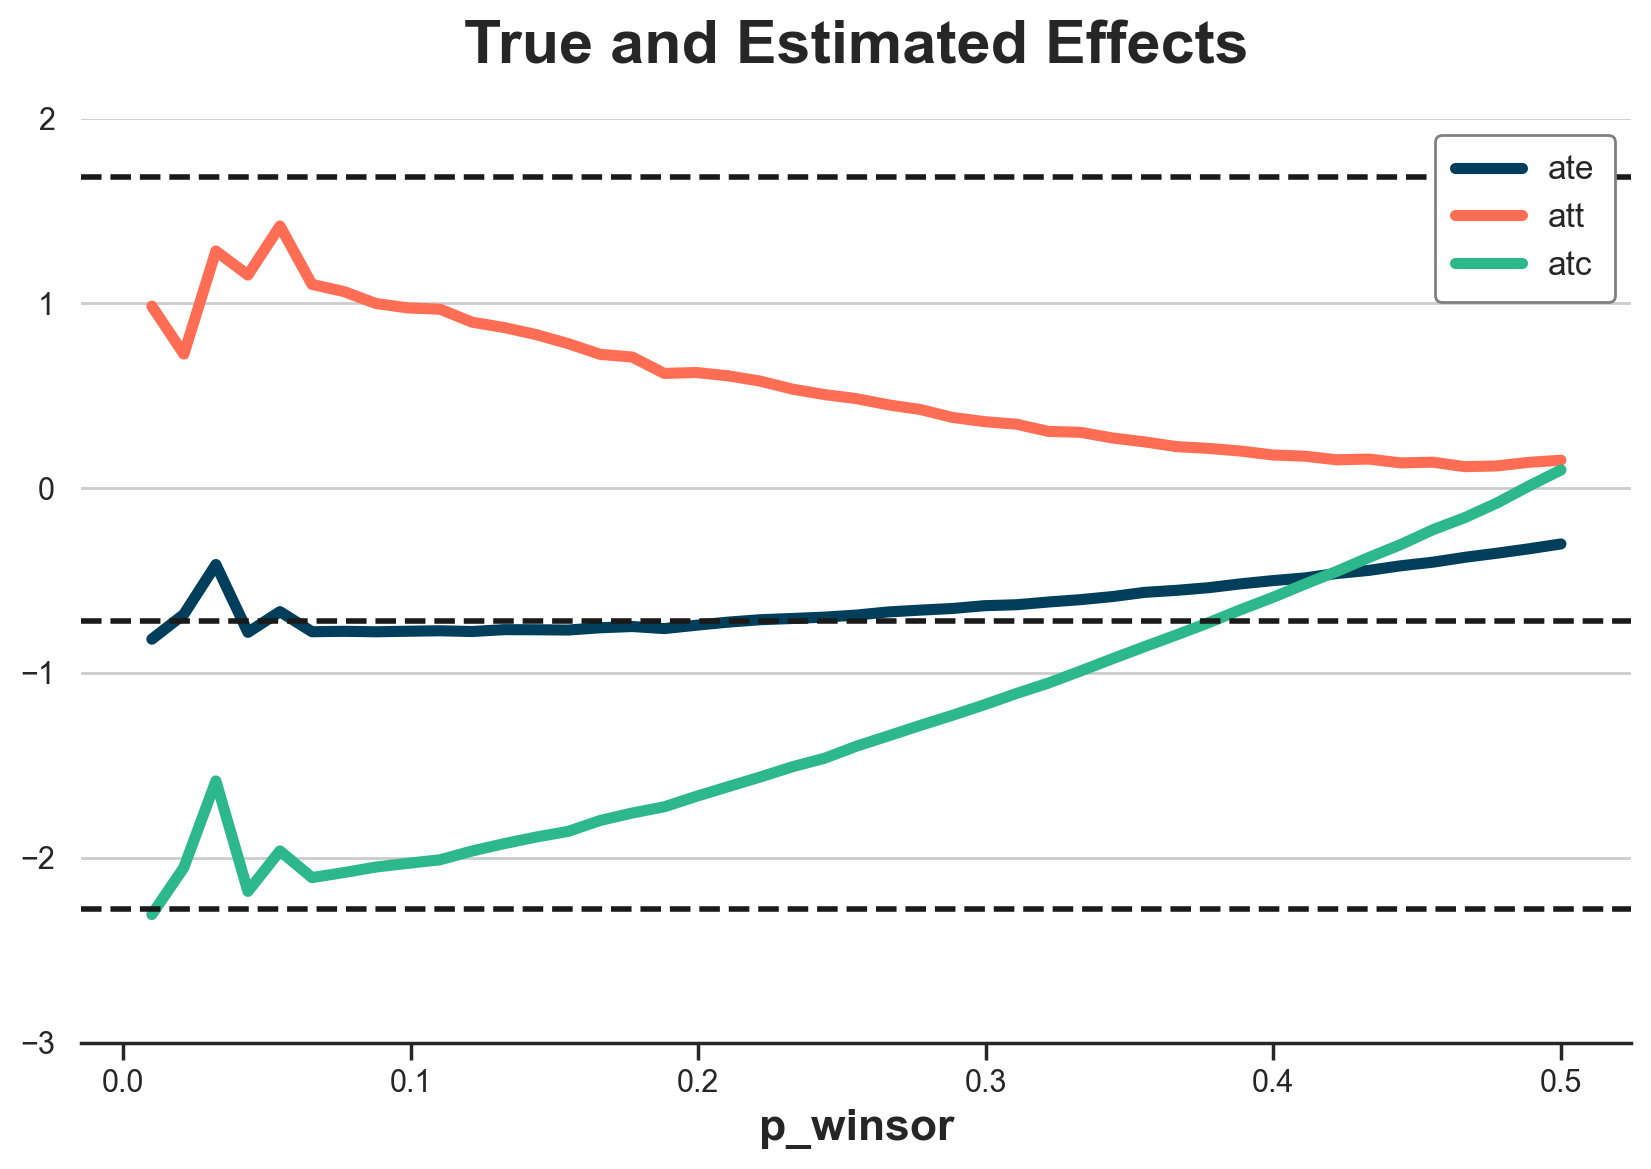

In [46]:
fig, ax = plt.subplots()
for i, estimand in enumerate(["ate", "att", "atc"]):
    g = sns.lineplot(data=df_estimates, x="p_winsor", y=estimand, c=f"C{i}", label=estimand, ax=ax)
g.set(title="True and Estimated Effects", ylim=(-3, 2), ylabel="")
ax.axhline(y=dfw.tau[dfw.w == 1].mean(), ls="--", lw=2, c="k");
ax.axhline(y=dfw.tau.mean(), ls="--", lw=2, c="k");
ax.axhline(y=dfw.tau[dfw.w == 0].mean(), ls="--", lw=2, c="k");

## Proportional Differences

Ok, so far we played in DiD home, and DML did not perform too terribly. What if we change the model?

Consider the case in which market-level shocks are **multiplicative** instead of additive. This is a more realistic case in many applications. The outcome model then becomes.

$$
Y_{it} = \gamma_t * (\alpha_i  + f(\alpha_i) W_{it} + \epsilon_{it})
$$

In [47]:
class DGPSelectionOnUnobservables2(DGPSelectionOnUnobservables):

    def add_potential_outcomes(self, df: pd.DataFrame, seed: int = 0) -> pd.DataFrame:
        """Adds potential outcomes to the dataframe."""                
        df["y_w0"] = df["shock_t"] * (df["type_i"] + df["shock_it"])
        df["tau"] = 3 * (np.sqrt(df["type_i"]) - 2)
        df["y_w1"] = df["y_w0"] + df["tau"]
        return df

Let's generate the data.

In [48]:
dgp2 = DGPSelectionOnUnobservables2(n=10_000, t=2)
df2, dfw2 = dgp2.generate_data(drop_unobservables=False)

Print the true treatment effects.

In [49]:
print_true_effects(dfw2)

ATE: -0.72 ± 0.03
ATT: 1.69 ± 0.04
ATC: -2.28 ± 0.02


Run difference-in-differences estimator. It is sensibly off. It predicts a negative treatment effect while *all* individual treatment effects are positive. Mmm

In [50]:
smf.ols("y ~ 1 + t * w", data=df2).fit(cov_type="cluster", cov_kwds={"groups": df.i}).summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,2.8173,0.031,91.270,0.000,2.757,2.878
t,-2.1408,0.024,-90.664,0.000,-2.187,-2.094
w,7.9364,0.111,71.815,0.000,7.720,8.153
t:w,-4.3450,0.051,-85.224,0.000,-4.445,-4.245


What about double machine learning?

In [51]:
%%capture
model_t = WinsorizedLGBMClassifier(n_estimators=500)
model_y = LGBMRegressor(n_estimators=500)
model_trimmed2 = CausalForestDML(model_t=model_t, model_y=model_y, discrete_treatment=True).fit(X=dfw2[["y_t0"]], T=dfw2["w"], Y=dfw2["y_t1"])

The model is doing fairly well! All estimates are fairly close, just a bit downward biased

In [52]:
print_model_estimates(model_trimmed2)

ATE: -0.59 ± 0.14
ATT: 1.82 ± 0.22
ATT: -1.94 ± 0.18


It seems that the model is struggling to extrapolate, but overall it does way better than DiD.

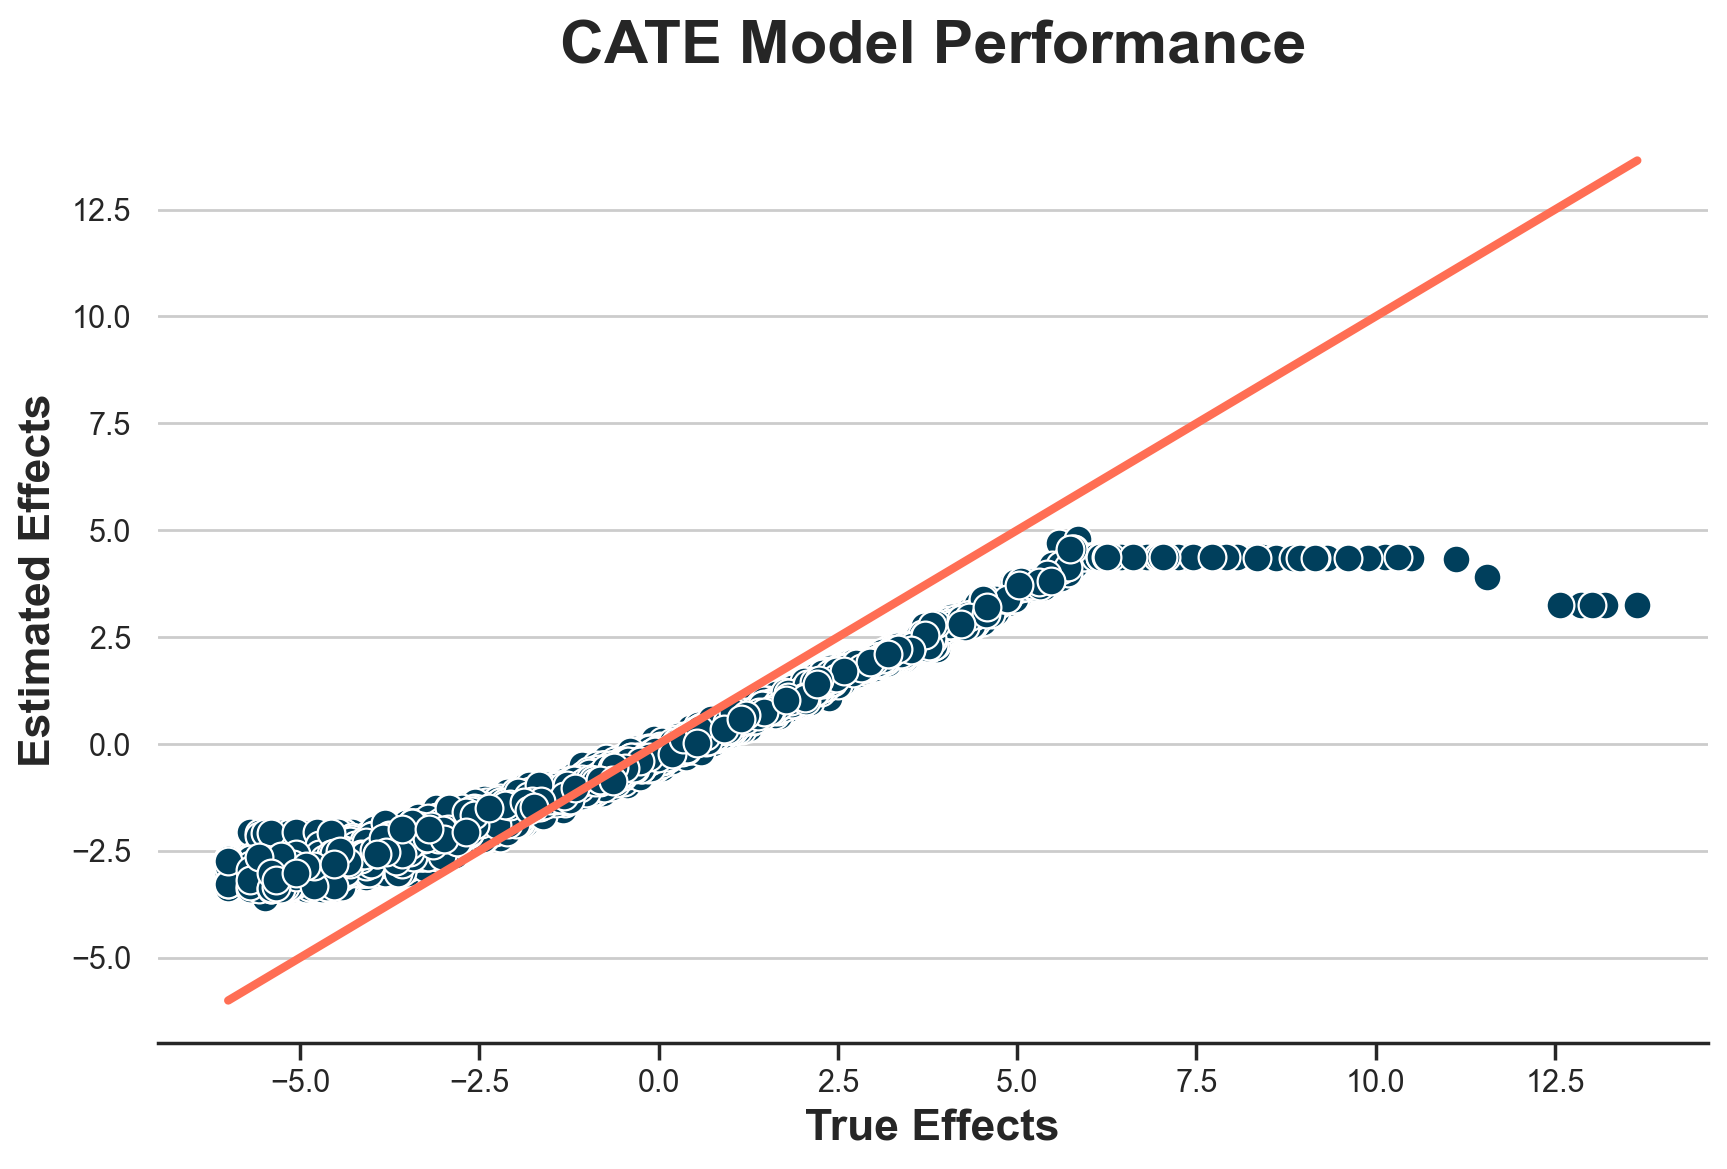

In [53]:
plot_model_estimates(model_trimmed2, dfw2)